# Compare methods notebook

In [1]:
import glob
import os
import gzip
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sys import getsizeof
from objsize import get_deep_size
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from result_classes import Result,MethodResults

In [2]:
prob_name = "Calcium_Oscillate"
methods = ["smc", "pmc"]#, "ptmcmc"]

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		with gzip.open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)		

## Calculate the percentage of runs that converged in PT-MCMC

In [3]:
try:
	ptmcmc_idx = methods.index("ptmcmc")
	ptmcmc_group = grouped_results[ptmcmc_idx]
	n_runs = len(ptmcmc_group.all_runs)
	n_converged = 0
	for i in range(n_runs):
		if ptmcmc_group.all_runs[i].converged:
			n_converged+=1
	print(f"{n_converged:d} of {n_runs:d} runs have converged\nConvergence percentage: {n_converged/n_runs:.2f}")
except ValueError:
	pass

## Plot the distribution of ALL likelihoods from ALL runs

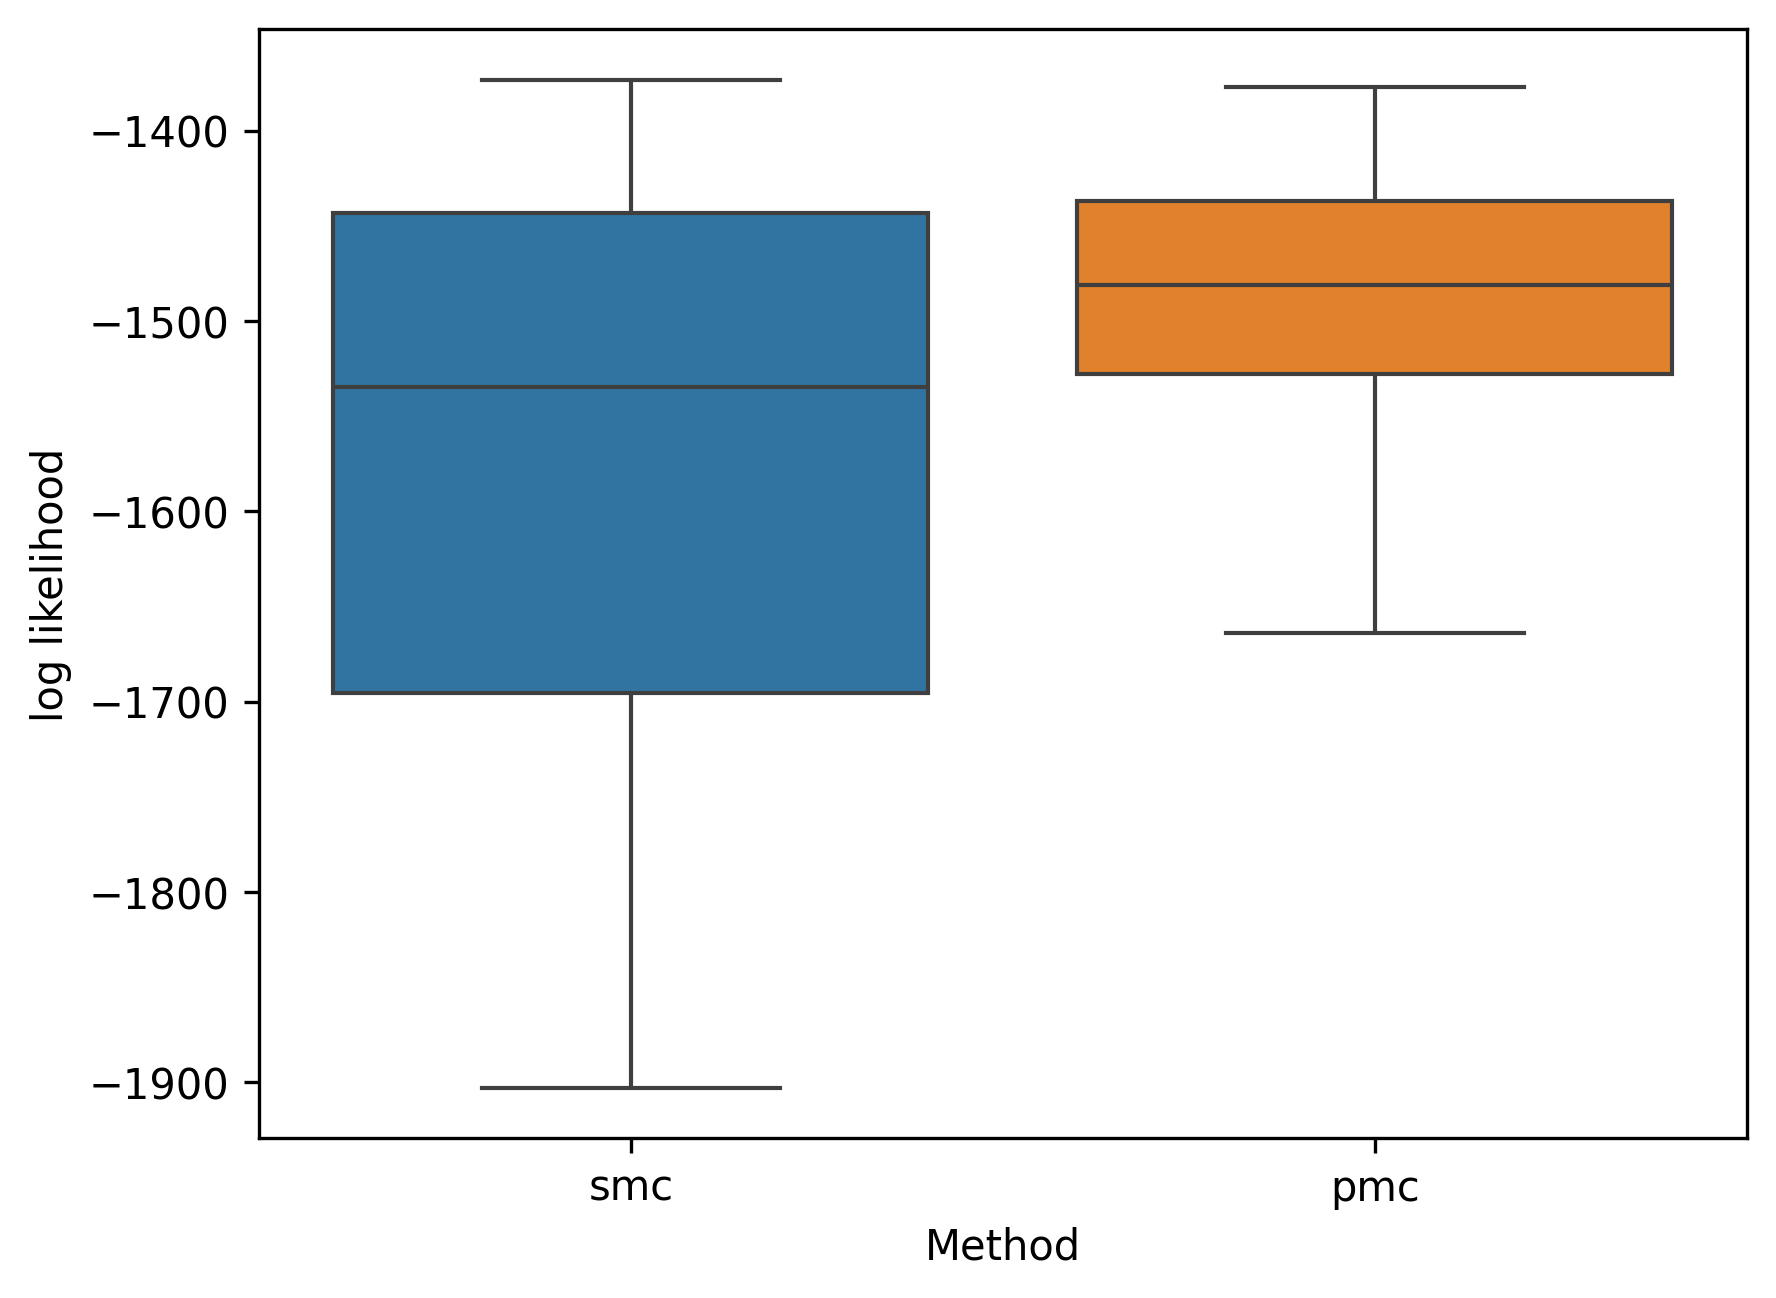

In [4]:
plt.figure(dpi=300)
llhs = np.array([x.get_llhs().flatten() for x in grouped_results], dtype=object)


#llhs[llhs<-20000] = -7500
llh_df = pd.DataFrame()
for llh_arr, method in zip(llhs, methods):
	temp_df = pd.DataFrame()
	temp_df[method] = llh_arr
	llh_df = pd.concat([llh_df, temp_df])

sns.boxplot(llh_df, showfliers=False)
plt.xlabel("Method"); plt.ylabel("log likelihood");

MAX NUM FUNC CALLS: 5672000


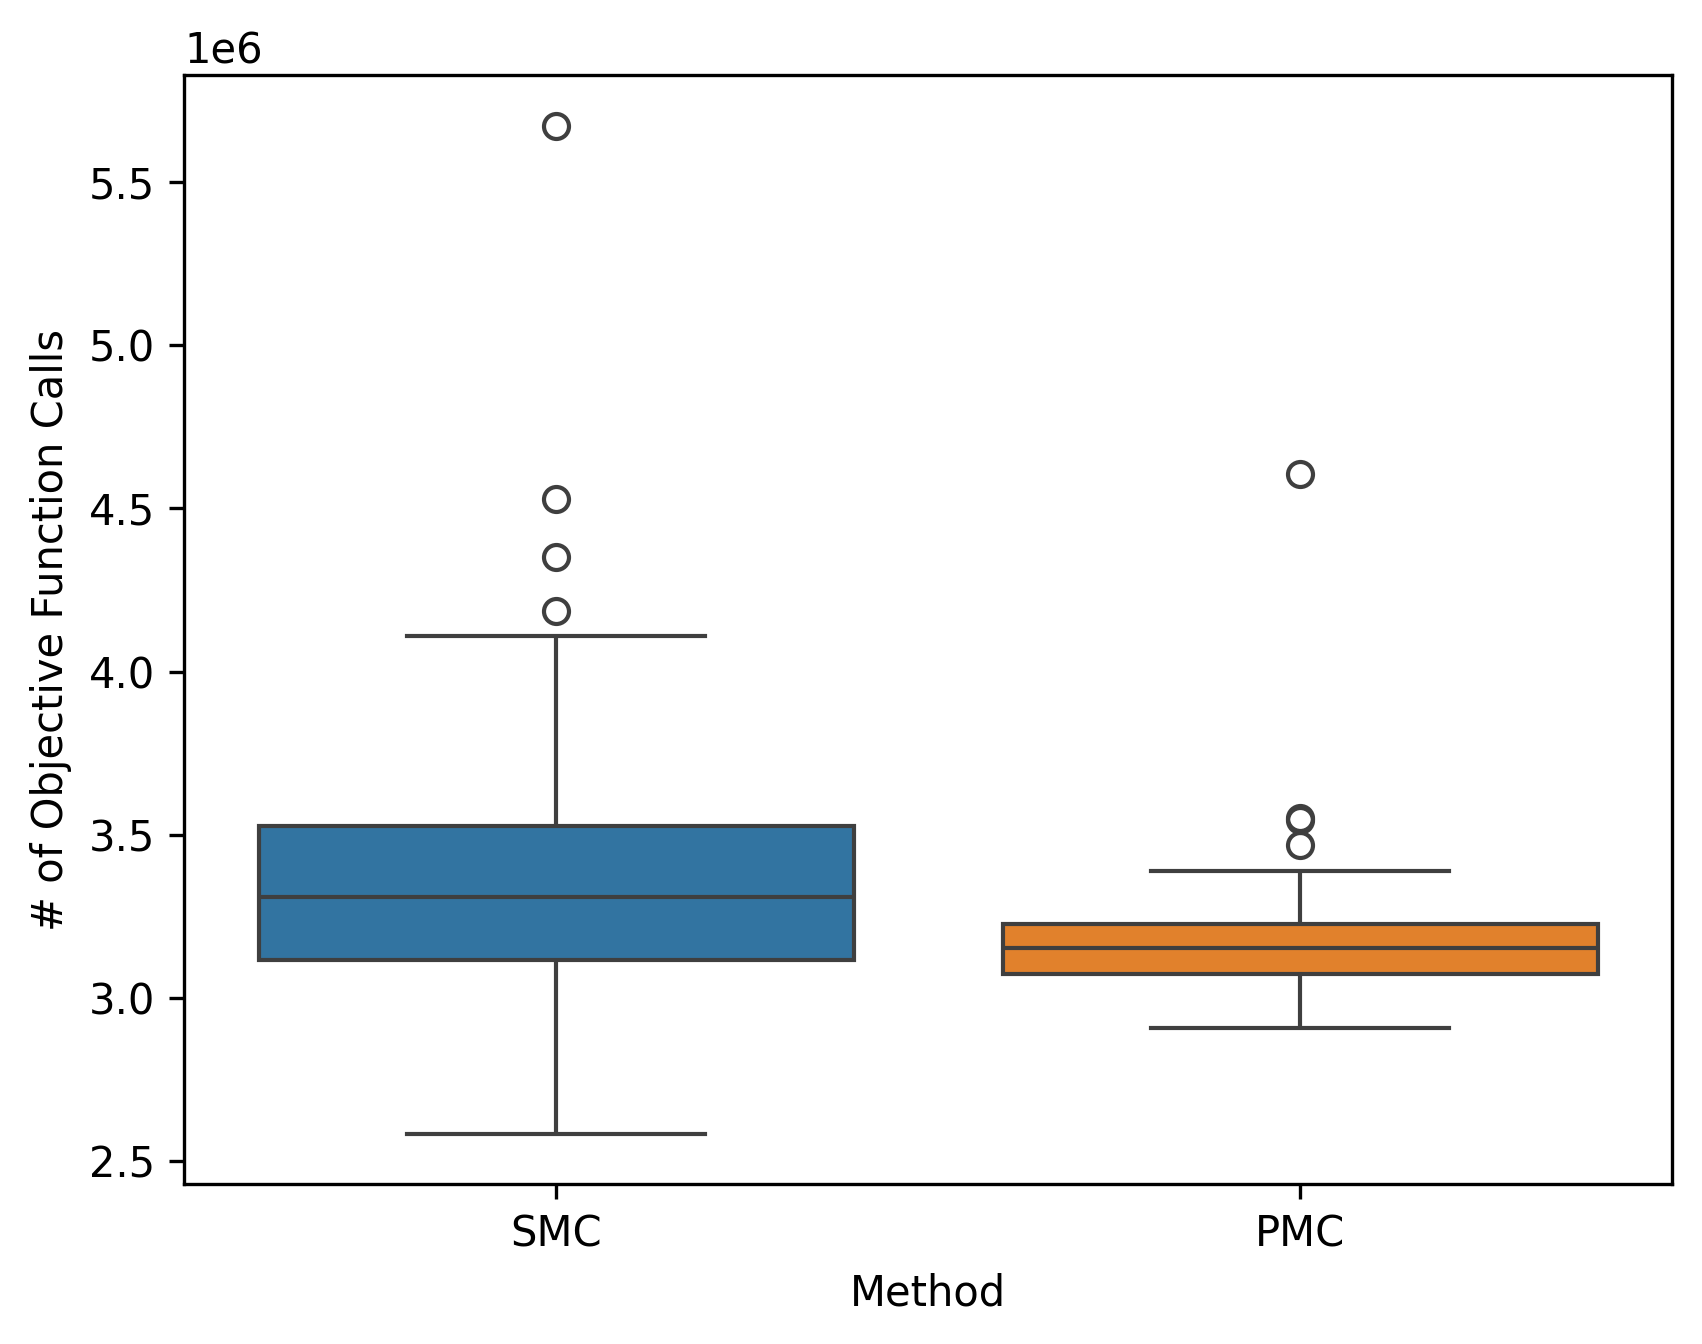

In [12]:
plt.figure(dpi=300)
calls = np.array([x.get_fun_calls() for x in grouped_results], dtype=object)

call_df = pd.DataFrame()
for call_arr, method in zip(calls, methods):
	temp_df = pd.DataFrame()
	temp_df[method] = call_arr
	call_df = pd.concat([call_df, temp_df])

sns.boxplot(call_df)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("# of Objective Function Calls");
print(f"MAX NUM FUNC CALLS: {np.max([max(x) for x in calls])}")

In [ ]:
llh_threshold = -1500
plt.figure(dpi=300)
#grouped_results[0].get_convergence_times(llh_threshold)
conv = np.array([x.get_convergence_times(llh_threshold) for x in grouped_results], dtype=object)
conv_df = pd.DataFrame()
for conv_arr, method in zip(conv, methods):
	temp_df = pd.DataFrame()
	temp_df[method] = conv_arr
	conv_df = pd.concat([conv_df, temp_df])

sns.violinplot(conv_df)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); 
plt.ylabel(f"# Function Evaluations until Convergence");